In [1]:
using DrWatson

@quickactivate "Hadjivasiliou_Julia_Tutorial"

projectname()

"Hadjivasiliou_Julia_Tutorial"

In [2]:
using DifferentialEquations
using Distributed
using Turing
using Distributions
using LinearAlgebra

using Plots
using StatsPlots

using Base.Threads
using Base.Threads: @spawn

# https://turing.ml/dev/docs/using-turing/guide


Next ODE: morphogen gradient - diffusion and linear degradation term

$\frac{\partial c}{\partial t} = D \frac{\partial ^ 2 c}{\partial x ^2}  - kc$

with source term $D\frac{\partial c}{\partial x}|_{x=0} = -j_0$ and zero flux at the end of the tissue, $D\frac{\partial c}{\partial x}|_{x=L} = 0$

The analytic solution $c(x) = c_0\exp(-x/\lambda$), where $c_0 = \frac{j_0}{\sqrt{Dk}}$ and $\lambda = \sqrt{\frac{D}{k}}$

MOL, Second-order central

https://www.stochasticlifestyle.com/solving-systems-stochastic-pdes-using-gpus-julia/

In [3]:
const Nc = 100
const L = 1.

const tissue = range(0,L,length = Nc)

const dx = step(tissue)
const h = 1/dx^2

const k = 1.
const j0 = 0.4

function morph_grad!(du,u,p,t)

    D = p

    du[1] = h*(2*u[2] + (2*dx*j0/D) - 2*u[1]) - k*u[1]

    @inbounds for j in 2:Nc-1
        du[j] =  D*h*(u[j-1] + u[j+1] - 2*u[j]) - k*u[j]
    end

    du[Nc] = h*(2*u[Nc-1] - 2*u[Nc]) - k*u[Nc]
    
end

morph_grad! (generic function with 1 method)

In [4]:
D = 0.16

p = (D)

u0 = zeros(Nc)

tspan = (0,12.)

prob = ODEProblem(morph_grad!,u0,tspan,p);

sol = solve(prob, AutoTsit5(Rosenbrock23()),save_everystep = false);

In [5]:
# https://turing.ml/dev/tutorials/10-bayesian-differential-equations/

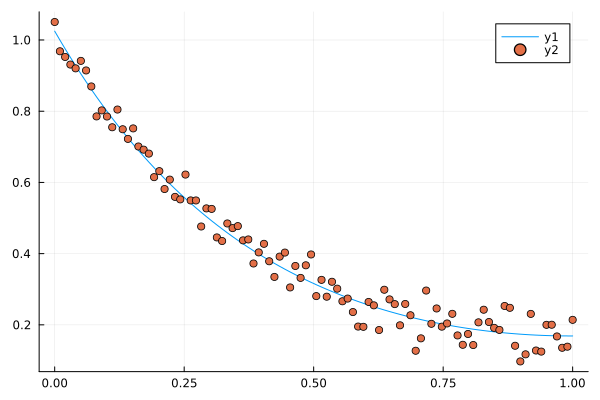

In [6]:
const σ_noise = 0.2

d = Normal(0.0,σ_noise^2)

odedata = sol(tspan[2]) .+ rand(d,length(sol(tspan[2])))

plot(tissue,sol.u[end])
scatter!(tissue,odedata)

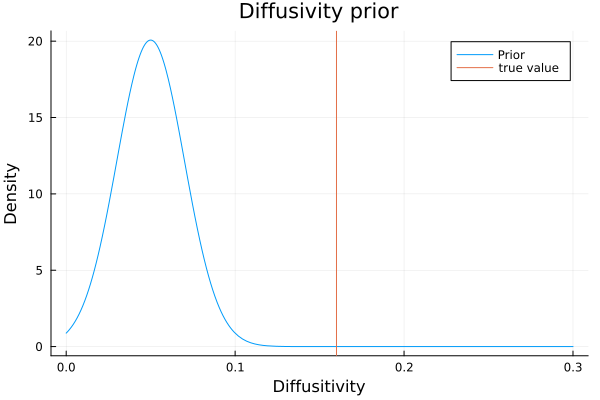

In [20]:
plot(truncated(Normal(0.05, 0.02); lower=0., upper=0.3),title = "Diffusivity prior", label = "Prior", xaxis = "Diffusitivity", yaxis = "Density")
vline!([D],label = "true value")

# savefig(plotsdir("DiffusitivityPrior.png"))

In [21]:
@model function fitlv(data, prob)
    # Prior distributions.
    D ~ truncated(Normal(0.05, 0.02); lower=0., upper=0.5)

    # Simulate morphogen model. 
    p = (D)
    predicted = solve(prob, AutoTsit5(Rosenbrock23()); p=p, save_everystep = false).u[end]

    data = MvNormal(predicted, σ_noise^2 * I)

    return nothing
end

fitlv (generic function with 2 methods)

In [22]:
model = fitlv(odedata, prob);

In [23]:
chain = sample(model, HMC(0.05, 10), MCMCSerial(), 10000, 1; progress=true)

Sampling (Chain 1 of 1)   0%|                           |  ETA: N/A


Sampling (Chain 1 of 1)   0%|▏                          |  ETA: 0:41:55


Sampling (Chain 1 of 1)   1%|▎                          |  ETA: 0:40:35


Sampling (Chain 1 of 1)   2%|▍                          |  ETA: 0:39:59


Sampling (Chain 1 of 1)   2%|▌                          |  ETA: 0:39:37


Sampling (Chain 1 of 1)   2%|▋                          |  ETA: 0:39:13


Sampling (Chain 1 of 1)   3%|▊                          |  ETA: 0:38:54


Sampling (Chain 1 of 1)   4%|█                          |  ETA: 0:38:44


Sampling (Chain 1 of 1)   4%|█▏                         |  ETA: 0:38:30


Sampling (Chain 1 of 1)   4%|█▎                         |  ETA: 0:38:24


Sampling (Chain 1 of 1)   5%|█▍                         |  ETA: 0:38:10


Sampling (Chain 1 of 1)   6%|█▌                         |  ETA: 0:37:56


Sampling (Chain 1 of 1)   6%|█▋                         |  ETA: 0:38:03


Sampling (Chain 1 of 1)   6%|█▊                         |  ETA: 0:37:48


Sampling (Chain 1 of 1)   7%|█▉                         |  ETA: 0:37:36


Sampling (Chain 1 of 1)   8%|██                         |  ETA: 0:37:21


Sampling (Chain 1 of 1)   8%|██▏                        |  ETA: 0:37:06


Sampling (Chain 1 of 1)   8%|██▎                        |  ETA: 0:36:51


Sampling (Chain 1 of 1)   9%|██▍                        |  ETA: 0:36:37


Sampling (Chain 1 of 1)  10%|██▋                        |  ETA: 0:36:24


Sampling (Chain 1 of 1)  10%|██▊                        |  ETA: 0:36:12


Sampling (Chain 1 of 1)  10%|██▉                        |  ETA: 0:35:58


Sampling (Chain 1 of 1)  11%|███                        |  ETA: 0:35:44


Sampling (Chain 1 of 1)  12%|███▏                       |  ETA: 0:35:30


Sampling (Chain 1 of 1)  12%|███▎                       |  ETA: 0:35:17


Sampling (Chain 1 of 1)  12%|███▍                       |  ETA: 0:35:05


Sampling (Chain 1 of 1)  13%|███▌                       |  ETA: 0:34:51


Sampling (Chain 1 of 1)  14%|███▋                       |  ETA: 0:34:38


Sampling (Chain 1 of 1)  14%|███▊                       |  ETA: 0:34:26


Sampling (Chain 1 of 1)  14%|███▉                       |  ETA: 0:34:14


Sampling (Chain 1 of 1)  15%|████                       |  ETA: 0:34:01


Sampling (Chain 1 of 1)  16%|████▏                      |  ETA: 0:33:49


Sampling (Chain 1 of 1)  16%|████▍                      |  ETA: 0:33:36


Sampling (Chain 1 of 1)  16%|████▌                      |  ETA: 0:33:23


Sampling (Chain 1 of 1)  17%|████▋                      |  ETA: 0:33:10


Sampling (Chain 1 of 1)  18%|████▊                      |  ETA: 0:32:58


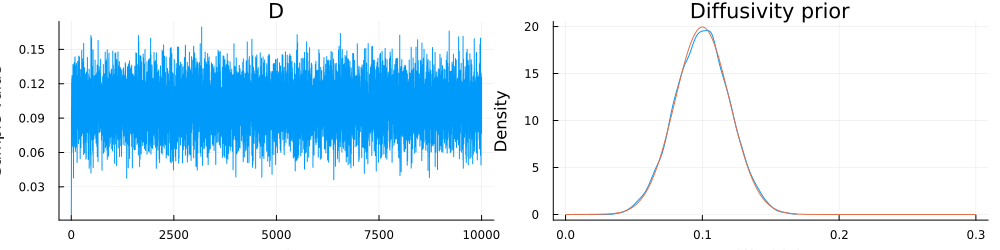

In [17]:
f = plot(chain)
plot!(f[2],truncated(Normal(0.1, 0.02); lower=0., upper=0.3),title = "Diffusivity prior", label = "Prior", xaxis = "Diffusitivity", yaxis = "Density")